In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

In [3]:
# Hyperparameters
latent_dim = 100
ngf = 64  # Number of generator filters
ndf = 64  # Number of discriminator filters
image_size = 32
nc = 3    # Number of channels (3 for RGB)
batch_size = 128
num_epochs = 100
lr = 0.0002
beta1 = 0.5  # Beta1 for Adam optimizer

In [4]:
# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State size: (ngf*4) x 4 x 4
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State size: (ngf*2) x 8 x 8
            
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State size: ngf x 16 x 16
            
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # State size: nc x 32 x 32
        )
        
    def forward(self, x):
        return self.main(x.view(-1, latent_dim, 1, 1))

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input is nc x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: ndf x 16 x 16
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf*2) x 8 x 8
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf*4) x 4 x 4
            
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # State size: 1 x 1 x 1
        )
        
    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)

# Custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                     download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size,
                       shuffle=True, num_workers=2)

# Initialize networks
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Apply custom weights initialization
generator.apply(weights_init)
discriminator.apply(weights_init)

# Setup optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
criterion = nn.BCELoss()

Files already downloaded and verified


In [6]:
# Training function with visualization
def train():
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
    g_losses = []
    d_losses = []
    #images = []
    
    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            # Train Discriminator
            discriminator.zero_grad()
            label_real = torch.ones(batch_size, device=device)
            label_fake = torch.zeros(batch_size, device=device)
            
            output_real = discriminator(real_images)
            d_loss_real = criterion(output_real, label_real)
            
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach())
            d_loss_fake = criterion(output_fake, label_fake)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()
            
            # Train Generator
            generator.zero_grad()
            output_fake = discriminator(fake_images)
            g_loss = criterion(output_fake, label_real)
            g_loss.backward()
            g_optimizer.step()
            
            if i % 100 == 0:
                print(f'Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] '
                      f'D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}')
                
        # Save losses for plotting
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

            
        
        
    # Generate and save sample images
    with torch.no_grad():
        fake_images = generator(fixed_noise)
        images = torchvision.utils.make_grid(fake_images[:64], normalize=True)
        
    
    return g_losses, d_losses, images

In [7]:
# Train the model
print("Starting Training...")
g_losses, d_losses, generated_images = train()

Starting Training...
Epoch [0/100] Batch [0/391] D_loss: 1.6072 G_loss: 1.9758
Epoch [0/100] Batch [100/391] D_loss: 0.0776 G_loss: 6.0024
Epoch [0/100] Batch [200/391] D_loss: 0.1931 G_loss: 4.9349
Epoch [0/100] Batch [300/391] D_loss: 0.4581 G_loss: 4.4863
Epoch [1/100] Batch [0/391] D_loss: 0.2645 G_loss: 4.3620
Epoch [1/100] Batch [100/391] D_loss: 0.2280 G_loss: 4.1352
Epoch [1/100] Batch [200/391] D_loss: 0.3181 G_loss: 3.4355
Epoch [1/100] Batch [300/391] D_loss: 0.3515 G_loss: 3.7236
Epoch [2/100] Batch [0/391] D_loss: 0.2722 G_loss: 3.8473
Epoch [2/100] Batch [100/391] D_loss: 0.2070 G_loss: 3.5301
Epoch [2/100] Batch [200/391] D_loss: 0.7020 G_loss: 1.8728
Epoch [2/100] Batch [300/391] D_loss: 0.4311 G_loss: 4.7363
Epoch [3/100] Batch [0/391] D_loss: 0.6078 G_loss: 3.2007
Epoch [3/100] Batch [100/391] D_loss: 0.3094 G_loss: 3.4183
Epoch [3/100] Batch [200/391] D_loss: 0.3657 G_loss: 2.7746
Epoch [3/100] Batch [300/391] D_loss: 0.3462 G_loss: 3.7803
Epoch [4/100] Batch [0/391]

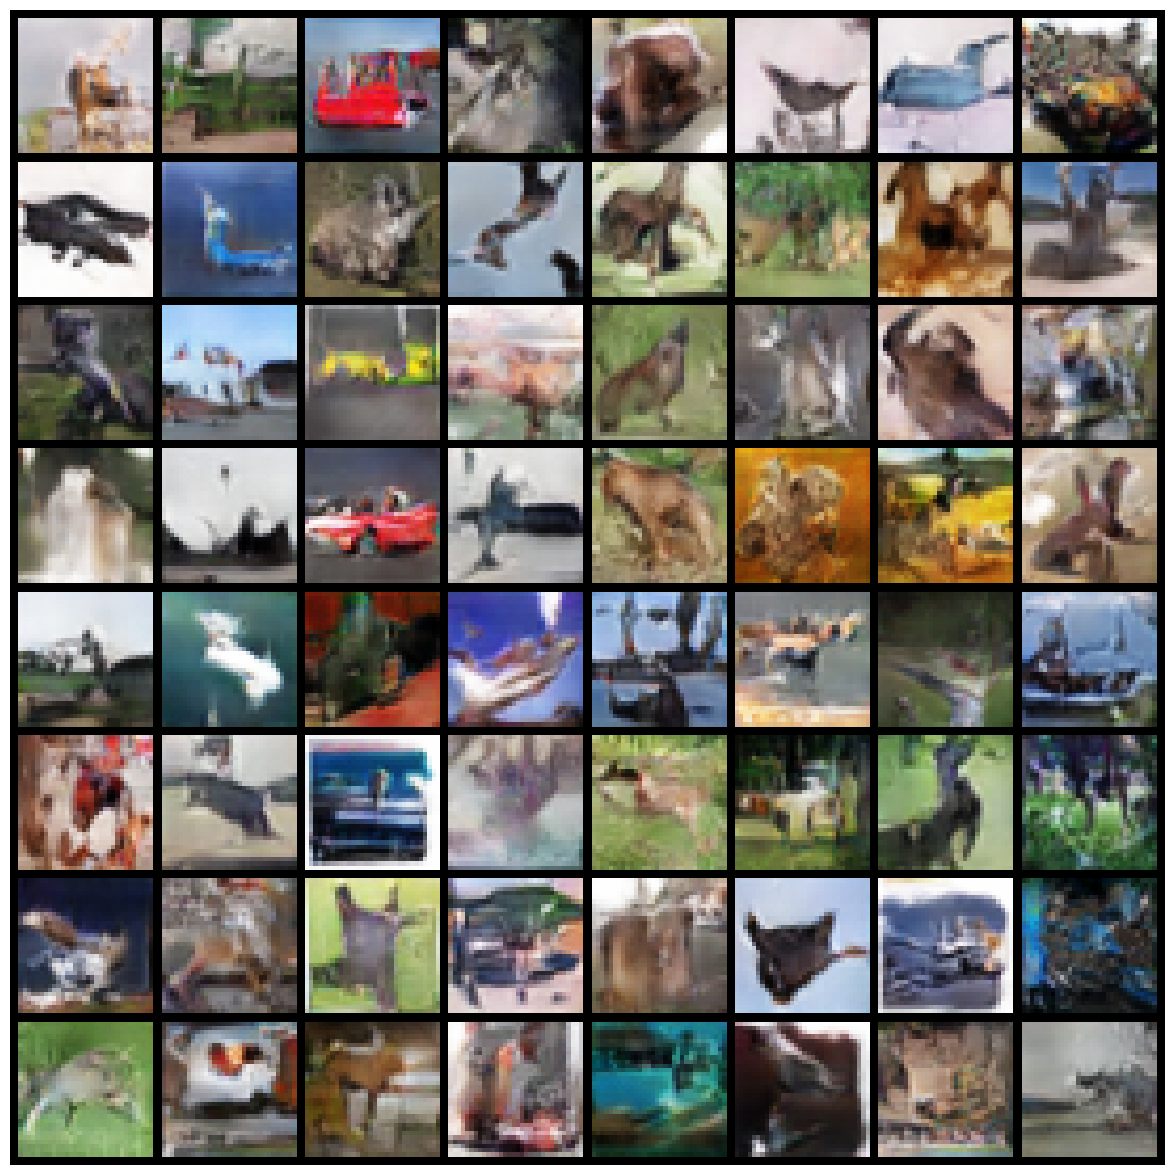

In [9]:
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(generated_images.cpu().numpy().transpose(1, 2, 0))
plt.show()

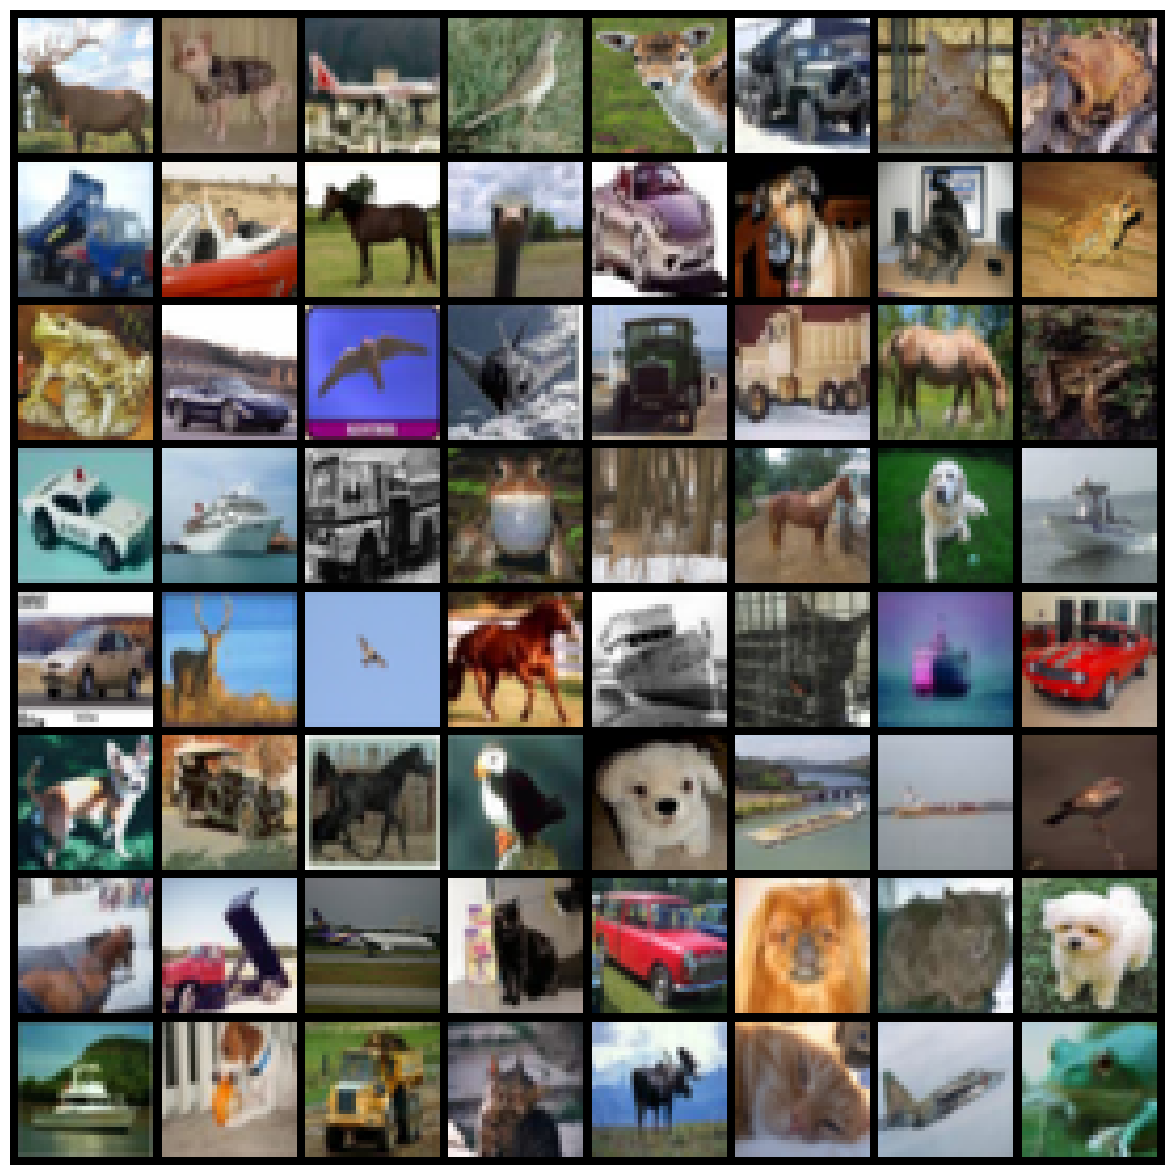

In [20]:
for i, (real_images, _) in enumerate(dataloader):
    r_images = torchvision.utils.make_grid(real_images[:64], normalize=True)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(r_images.cpu().numpy().transpose(1, 2, 0))
plt.show()